# Final Version of Phydra GEKKO Core v1
this is the very basis of core processes that was used for the first published version

can be used to develop the framework further in a smaller test environment, in these early versions

In [188]:
from gekko import GEKKO

m = GEKKO(remote=False)


gk_array = m.Array(m.SV, (2,2))

it = np.nditer(gk_array, flags=['refs_ok','multi_index'], op_flags=['readwrite'])
i=0
while not it.finished:
    gk_array[it.multi_index].__dict__['NAME'] = f"{'X'}_{str(i)}"
    gk_array[it.multi_index].VALUE = 1
    i += 1
    it.iternext()

In [207]:
x = np.array([m.SV(name=f"hello_{i}", value=1) for i in range(2)])

In [206]:
[SV.name for SV in x]

['hello_0', 'hello_1']

# TODO:
X 1. add value storage, both in Env and Comp
X 2. add a simple flux
# 3. test dim init: within Comp 1D (, within Env, flexible)

#IDEA:

#remove the ENVS for noW! none of my use cases actually employ it!
#so it would be awkward to present it there like that!!!

instead, just basic 0D model, but clean interface should be the goal!

in effect, as long as I use m.Array instead of m.SV, I should be able to add any kind of dims later on!

In [ ]:
class FunctionalGroup(GekkoContext):
    """ creates array of state variables """
    
    label = xs.variable(intent='out', description='the label supplied at model initialisation')
    value = xs.variable(intent='out', dims=('not_initalized', 'time'), description='stores output in dimensions supplied to process_setup')
    
    num = xs.variable(intent='in', description='number of state variables within group')
    initVal = xs.variable(intent='inout', description='initial value of component')
    
    SV = xs.any_object(description='stores the gekko variable')
    
    # Simulation stages
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"functional group {self.label} is initialized with size {self.num}")
        
        self.create_index()
        
        self.m.phydra_SVs[self.label] = np.array([self.m.SV(name=f"{self.label}_{i}", value=self.initVal, lb=0) for i in range(self.num)])
        self.value = [sv.value for sv in self.m.phydra_SVs[self.label]]
        
    def run_step(self):
        print(f"assembling Equations for {self.label}")

        gk_array = self.m.phydra_SVs[self.label]
        fluxes = self.m.phydra_fluxes[self.label]
        for i in range(self.num):
            self.m.Equation(gk_array[i].dt() == sum([flux[i] for flux in fluxes]))
    
    # Helper functions
    def create_index(self):
        # this creates numbered index with label:
        if self.num == 1:
            index_list = [f"{self.label}"]
        else:
            index_list = [f"{self.label}-{i}" for i in range(self.num)]
        setattr(self, self.label, index_list)
    
    @classmethod
    def setup(cls, dim_label):
        """ create copy of process class with user specified name and dimension label """
        new_cls = type(cls.__name__ + dim_label, cls.__bases__, dict(cls.__dict__))
        # add new index with variable name of label (to avoid Zarr storage conflicts)
        new_dim = xs.index(dims=dim_label, groups='comp_index')
        setattr(new_cls, dim_label, new_dim)
        # modify dimensions 
        new_cls.value.metadata['dims'] = ((dim_label, 'time'),)
        # return intialized xsimlab process
        return xs.process(new_cls)

In [827]:
class FunctionalGroup:
    """ 
    undecorated class to create xs.process functional group 
    containing multiple state variables that share fluxes
    """
    label = xs.variable(intent='out', description='the label supplied at model initialisation')
    value = xs.variable(intent='out', dims=('not_initalized', 'time'), description='stores output in dimensions supplied to process_setup')
    
    num = xs.variable(intent='in', description='number of state variables within group')
    initVal = xs.variable(intent='inout', description='initial value of component')
    
    m = xs.foreign(GekkoCore, 'm')# this is inherited from other processes and setup
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"functional group {self.label} is initialized with size {self.num}")
        
        # this creates numbered index with label:
        if self.num == 1:
            index_list = [f"{self.label}"]
        else:
            index_list = [f"{self.label}-{i}" for i in range(self.num)]
        setattr(self, self.label, index_list)
        
        self.m.phydra_SVs[self.label] = np.array([self.m.SV(name=f"{self.label}_{i}", value=self.initVal) for i in range(self.num)])
        self.value = [sv.value for sv in self.m.phydra_SVs[self.label]]
        
    def run_step(self):
        print(f"assembling Equations for {self.label}")
        
        # This is the special step needed for the gekko backend, where the equations are assembled
        # from all initialized influx in previous initialize step

        gk_array = self.m.phydra_SVs[self.label]
        fluxes = self.m.phydra_fluxes[self.label]
        for i in range(self.num):
            self.m.Equation(gk_array[i].dt() == sum([flux[i] for flux in fluxes]))
            
    @classmethod
    def setup(cls, dim_label):
        """ create copy of process class with user specified name and dimension label """
        # have to create a copy of the class, so that classmethod does not modify the base class
        new_cls = type(cls.__name__ + dim_label, cls.__bases__, dict(cls.__dict__))
        
        # add new index with variable name of label (to avoid Zarr storage conflicts)
        new_dim = xs.index(dims=dim_label, groups='comp_index')
        setattr(new_cls, dim_label, new_dim)
        
        # modify dimensions 
        new_cls.value.metadata['dims'] = ((dim_label, 'time'),)
        
        # return intialized xsimlab process
        return xs.process(new_cls)

In [727]:
Test.__dict__

mappingproxy({'__module__': '__main__',
              'output': _CountingAttr(counter=1319, _default=NOTHING, repr=True, eq=True, order=True, hash=None, init=True, metadata={'var_type': <VarType.VARIABLE: 'variable'>, 'dims': ((),), 'intent': <VarIntent.IN: 'in'>, 'groups': (), 'static': False, 'attrs': {}, 'description': '', 'encoding': {}}),
              'create': <classmethod at 0x11718c280>,
              '__dict__': <attribute '__dict__' of 'Test' objects>,
              '__weakref__': <attribute '__weakref__' of 'Test' objects>,
              '__doc__': None})

In [728]:
Test.create('hey').__dict__

mappingproxy({'__module__': '__main__',
              'create': <classmethod at 0x11718c280>,
              '__dict__': <attribute '__dict__' of 'Test' objects>,
              '__weakref__': <attribute '__weakref__' of 'Test' objects>,
              '__doc__': "\n\n    Attributes\n    ----------\n    output : :class:`attr.Attribute`\n        No description given\n\n        Variable properties:\n\n        - type : ``variable``\n        - intent : ``in``\n        - dimensions : ('hey', 'time')\n\n",
              '__attrs_attrs__': (Attribute(name='output', default=NOTHING, validator=None, repr=True, eq=True, order=True, hash=None, init=True, metadata=mappingproxy({'var_type': <VarType.VARIABLE: 'variable'>, 'dims': (('hey', 'time'),), 'intent': <VarIntent.IN: 'in'>, 'groups': (), 'static': False, 'attrs': {}, 'description': '', 'encoding': {}}), type=None, converter=None, kw_only=True)),
              '__eq__': <function __main__.hey.__eq__(self, other)>,
              '__ne__': <functi

In [820]:
class FunctionalGroup(GekkoContext):
    """ creates array of state variables """
    
    label = xs.variable(intent='out', description='the label supplied at model initialisation')
    value = xs.variable(intent='out', dims=('not_initalized', 'time'), description='stores output in dimensions supplied to process_setup')
    
    num = xs.variable(intent='in', description='number of state variables within group')
    initVal = xs.variable(intent='inout', description='initial value of component')
    
    SV = xs.any_object(description='stores the gekko variable')
    
    # Simulation stages
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"functional group {self.label} is initialized with size {self.num}")
        
        self.create_index()
        
        self.m.phydra_SVs[self.label] = np.array([self.m.SV(name=f"{self.label}_{i}", value=self.initVal) for i in range(self.num)])
        self.value = [sv.value for sv in self.m.phydra_SVs[self.label]]
        
    def run_step(self):
        print(f"assembling Equations for {self.label}")

        gk_array = self.m.phydra_SVs[self.label]
        fluxes = self.m.phydra_fluxes[self.label]
        for i in range(self.num):
            self.m.Equation(gk_array[i].dt() == sum([flux[i] for flux in fluxes]))

    # Helper functions
    def create_index(self):
        # this creates numbered index with label:
        if self.num == 1:
            index_list = [f"{self.label}"]
        else:
            index_list = [f"{self.label}-{i}" for i in range(self.num)]
        setattr(self, self.label, index_list)
    
    @classmethod
    def setup(cls, dim_label):
        """ create copy of process class with user specified name and dimension label """
        new_cls = type(cls.__name__ + dim_label, cls.__bases__, dict(cls.__dict__))
        # add new index with variable name of label (to avoid Zarr storage conflicts)
        new_dim = xs.index(dims=dim_label, groups='comp_index')
        setattr(new_cls, dim_label, new_dim)
        # modify dimensions 
        new_cls.value.metadata['dims'] = ((dim_label, 'time'),)
        # return intialized xsimlab process
        return xs.process(new_cls)

In [825]:
MODEL = xs.Model({'core':GekkoCore,
                  'solver':GekkoSequentialSolve,
                  'time':Time,
                  'N':StateVariable, 
                  'P':FunctionalGroup.setup('P')})

MODEL

<xsimlab.Model (5 processes, 3 inputs)>
core
solver
time
    days        [in] ('time',) time in days
N
P
    initVal  [inout] initial value of component
    num         [in] number of state variables within group

In [826]:
in_ds = xs.create_setup(model=MODEL,
                        clocks={'clock': [0,1]},
                        input_vars={
                            'time__days': ('time', np.arange(0, 10, .1)),
                            'N':{'initVal':1},
                            'P':{'num':6,
                                'initVal':.1}
                        },
                        output_vars={
                            'N__value':None,
                            'P__value':None}
                        )

in_ds

KeyError: "('N', 'initVal') is/are not valid key(s) for input variables in model <xsimlab.Model (5 processes, 3 inputs)>\ncore\nsolver\ntime\n    days        [in] ('time',) time in days\nN\nP\n    initVal  [inout] initial value of component\n    num         [in] number of state variables within group\n"

In [824]:
with MODEL:
    out_ds = in_ds.xsimlab.run()

initializing model core
Initializing Model Time
functional group N is initialized with size 4
functional group P is initialized with size 6
assembling Equations for N
assembling Equations for P
['time', 'n_0', 'n_1', 'n_2', 'n_3', 'p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'p_5']
Running solver now
Model was solved in 1.04 seconds
assembling Equations for N
assembling Equations for P
['time', 'n_0', 'n_1', 'n_2', 'n_3', 'p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'p_5']
Running solver now


Exception: @error: Degrees of Freedom
 * Error: DOF must be zero for this mode
 STOPPING...


In [793]:
out_ds

<xarray.Dataset>
Dimensions:  (N: 4, P: 6, clock: 2)
Coordinates:
  * N        (N) <U3 'N-0' 'N-1' 'N-2' 'N-3'
  * P        (P) <U3 'P-0' 'P-1' 'P-2' 'P-3' 'P-4' 'P-5'
  * clock    (clock) int64 0 1
Data variables:
    N__dim   int64 4
    P__dim   int64 6

In [744]:
StateVariable.process_setup(label='Q')

__main__.StateVariableQ

In [568]:
Model(dim=5).initialize()

TypeError: 'Model' object is not callable

In [13]:
from gekko import GEKKO
import xsimlab as xs
import numpy as np

# to create dynamic storage of fluxes
from collections import defaultdict

# to measure process time
import time as tm

In [14]:
# a function to randomly generate simple string as label for 
    # xsimlab dimension that should be flexible (scalar or list)
    
import string
import random

def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [39]:
@xs.process
class GekkoCore:
    m = xs.any_object()
    
    def initialize(self):
        print('initializing model core')
        self.m = GEKKO(remote=False, name='phydra')
        
        # add defaultdict of list that dynamically stores fluxes by component label
        self.m.phydra_fluxes = defaultdict(list)
        # same for state variables
        self.m.phydra_SVs = defaultdict()
        # same for forcings
        self.m.phydra_forcings = defaultdict()
        
    def finalize(self):
        print('finalizing gekko core: cleanup')
        #self.m.open_folder()
        self.m.cleanup()

        
@xs.process
class GekkoContext:
    """ Inherited by all other model processes to access GekkoCore"""
    m = xs.foreign(GekkoCore, 'm')

@xs.process
class Solver(GekkoContext):
    solver_type = xs.variable(intent='out')
    
@xs.process
class GekkoSequentialSolve(Solver):
    """takes time from Time process, needs to be added to model"""
    
    def initialize(self):
        self.solver_type = 'seq'
        
    def finalize_step(self):
        #print(self.m.__dict__)
        
        print([i.name for i in self.m._variables])
        print('Running solver now')
        
        # add solver options
        self.m.options.REDUCE = 3  # handles reduction of larger models, have not benchmarked it yet
        self.m.options.NODES = 3  # improves solution accuracy
        self.m.options.IMODE = 7  # sequential dynamic solver

        solve_start = tm.time()
        self.m.solve(disp=False)  # use option disp=True to print gekko output
        solve_end = tm.time()

        print(f"Model was solved in {round(solve_end-solve_start,2)} seconds")
        #print(self.m.__dict__)
        
        
@xs.process
class Time(GekkoContext):
    
    days = xs.variable(dims='time', description='time in days')
    # for indexing xarray IO objects
    time = xs.index(dims='time', description='time in days')

    def initialize(self):
        print('Initializing Model Time')
        self.time = self.days

        # ASSIGN MODEL SOLVING TIME HERE:
        self.m.time = self.time
        
        # add variable keeping track of time within model:
        self.m.phydra_SVs['time'] = self.m.Var(0, lb=0, name='time')
        self.m.Equation(self.m.phydra_SVs['time'].dt() == 1)
        
        
@xs.process
class StateVariable(GekkoContext):
    label = xs.variable(intent='out')
    
    value = xs.variable(intent='out', dims='time', description='stores the value of component state variable')
    SV = xs.any_object(description='stores the gekko variable')
    
    initVal = xs.variable(intent='in', description='initial value of component')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"state variable {self.label} is initialized")
        
        self.m.phydra_SVs[self.label] = self.m.SV(self.initVal, name=self.label)
        self.value = self.m.phydra_SVs[self.label].value
    
    def run_step(self):
        print('assembling Equations')
        print(self.m.phydra_fluxes)
        self.m.Equation(
            self.m.phydra_SVs[self.label].dt() == sum([flux for flux in self.m.phydra_fluxes[self.label]])
        )
        
        print([type(flux.value) for flux in self.m.phydra_fluxes[self.label]])
        print([eq.value for eq in self.m._equations])

        
class ProcessFactory:
    output = xs.variable(intent='out')
    
    @classmethod
    def create_process(self, dim_label):
        """ initialize process with custom dimension label """
        self.output.metadata['dims'] = ((dim_label, 'time'),)
        return xs.process(self)
    
    
class FunctionalGroup:
    """ this is necessary to supply specific dimension at """
    def __init__(self, dim_label):
        self.dim_label = dim_label
        
    def create_process(self):
        @xs.process
        class FunctionalGroupProcess(GekkoContext):
            """ creates array of state variables """
            label = xs.variable(intent='out')

            value = xs.variable(intent='out', dims=(self.dim_label, 'time'), description='stores the value of component state variable')
            SV = xs.any_object(description='stores the gekko variable')

            num = xs.variable(intent='in', description='number of state variables within group')
            initVal = xs.variable(intent='inout', description='initial value of component')

            def initialize(self):
                self.label = self.__xsimlab_name__
                print(f"functional group {self.label} is initialized with size {self.num}")

                self.m.phydra_SVs[self.label] = np.array([self.m.SV(name=f"{self.label}_{i}", value=self.initVal) for i in range(self.num)])
                self.value = [sv.value for sv in self.m.phydra_SVs[self.label]]

            def run_step(self):
                print(f"assembling Equations for {self.label}")

                gk_array = self.m.phydra_SVs[self.label]
                fluxes = self.m.phydra_fluxes[self.label]
                for i in range(self.num):
                    self.m.Equation(gk_array[i].dt() == sum([flux[i] for flux in fluxes]))

            def finalize_step(self):
                pass

        return FunctionalGroupProcess

class FunctionLibrary:
    def monod(Resource, Consumer, halfsat = 0.5):
        print(type(Resource), type(Consumer), type(halfsat))
        return Resource / (halfsat + Resource) * Consumer
    
    
@xs.process
class GrowthFlux(GekkoContext):
    label = xs.variable(intent='out')
    value = xs.variable(intent='out', dims='time')
    
    resource_label = xs.variable(intent='in')
    consumer_label = xs.variable(intent='in')
    halfsat = xs.variable(intent='in', description='half saturation constant')
    
    #flex dim input:
    #components = xs.variable(intent='in', dims=id_generator())
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"flux {self.label} of {self.consumer_label} consuming {self.resource_label} is initialized")
        
        self.resource = self.m.phydra_SVs[self.resource_label]
        self.consumer = self.m.phydra_SVs[self.consumer_label]
        
        self.halfsat_par = self.m.Param(self.halfsat, name='halfsat')
        
        flux = FunctionLibrary.monod(self.resource, self.consumer, self.halfsat_par)
        print(flux)
        self.value = self.m.Intermediate(flux, name='monod').value
        
        self.m.phydra_fluxes[self.resource_label].append(-flux)
        self.m.phydra_fluxes[self.consumer_label].append(flux)
        

@xs.process
class GrowthMultiFlux(GekkoContext):
    """ Functional Group growing on single ressource """
    label = xs.variable(intent='out')
    value = xs.variable(intent='out', dims=(id_generator(), 'time'))
    
    resource_label = xs.variable(intent='in')
    consumer_label = xs.variable(intent='in')
    halfsat = xs.variable(intent='inout', description='half saturation constant')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"flux {self.label} of {self.consumer_label} consuming {self.resource_label} is initialized")
        
        self.resource = np.array([self.m.phydra_SVs[self.resource_label]])
        self.consumer = self.m.phydra_SVs[self.consumer_label]
        
        self.halfsat_par = np.array([self.m.Param(self.halfsat, name='multi-halfsat')])
        
        print(self.resource, type(self.resource), self.consumer, type(self.consumer))
        print(self.resource * 2, self.consumer * 2)
        
        fluxes = FunctionLibrary.monod(self.resource, self.consumer, self.halfsat_par)
        
        print(fluxes)
        
        self.value = [self.m.Intermediate(flux).value for flux in fluxes]
        #self.value = np.array([self.m.Intermediate(fluxes[i], name=f"monod{i}").value for i in range(len(fluxes))], dtype='object')
        
        print('VALUE fg', self.value)
        
        self.m.phydra_fluxes[self.resource_label].append(-sum(fluxes))
        self.m.phydra_fluxes[self.consumer_label].append(fluxes)


@xs.process
class Forcing(GekkoContext):
    label = xs.variable(intent='out')
    value = xs.variable(intent='out', dims='time')
    
    initVal = xs.variable(intent='in')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"forcing {self.label} is initialized")
        
        self.m.phydra_forcings[self.label] = self.m.Param(self.initVal, name=self.label)
        self.value = self.m.phydra_forcings[self.label].value
    
    
@xs.process
class InFlux(GekkoContext):
    label = xs.variable(intent='out')
    value = xs.variable(intent='out', dims='time')
    
    forcing_label = xs.variable(intent='in')
    SV_label = xs.variable(intent='in')
    
    flowrate = xs.variable(intent='in', description='half saturation constant')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"flux {self.label} of {self.forcing_label} flowing to {self.SV_label} is initialized")
        
        self.forcing = self.m.phydra_forcings[self.forcing_label]
        
        self.flowrate_par = self.m.Param(self.flowrate, name='flowrate')
        
        flux = self.flowrate * self.forcing
        
        self.value = self.m.Intermediate(flux, name='influx').value
        
        self.m.phydra_fluxes[self.SV_label].append(flux)

In [143]:
def add_defaults(cls, dim_label):
    setattr(cls, 'x', xs.variable(intent='out', dims=dim_label))
    return cls

In [145]:
Test.__dict__

mappingproxy({'__module__': '__main__',
              '__dict__': <attribute '__dict__' of 'Test' objects>,
              '__weakref__': <attribute '__weakref__' of 'Test' objects>,
              '__doc__': '\n\n    Attributes\n    ----------\n    x : :class:`attr.Attribute`\n        No description given\n\n        Variable properties:\n\n        - type : ``variable``\n        - intent : ``in``\n        - dimensions : ()\n\n',
              '__attrs_attrs__': (Attribute(name='x', default=NOTHING, validator=None, repr=True, eq=True, order=True, hash=None, init=True, metadata=mappingproxy({'var_type': <VarType.VARIABLE: 'variable'>, 'dims': ((),), 'intent': <VarIntent.IN: 'in'>, 'groups': (), 'static': False, 'attrs': {}, 'description': '', 'encoding': {}}), type=None, converter=None, kw_only=True)),
              '__eq__': <function __main__.Test.__eq__(self, other)>,
              '__ne__': <function xsimlab.process.Test.__ne__(self, other)>,
              '__lt__': <function __main__.

In [141]:
x = add_defaults(Test, 'X')

In [49]:
@xs.process
class ParameterSetup:
    parameter = xs.foreign(GrowthMultiFlux, 'halfsat', intent='out')
    
    num = xs.foreign(GrowthMultiFlux, 'halfsat')
    
    def initialize(self):
        self.parameter = 

In [50]:
a = xs.Model({'core':GekkoCore, 
              'solver':GekkoSequentialSolve, 
              
              'time':Time, 
              
              'N':StateVariable, 
              'P':StateVariable,
              
              'X':FunctionalGroup('X').create_process(),
              
              'N0':Forcing,
              
              'growth':GrowthFlux,
              'FG_growth':GrowthMultiFlux,
             
              'N_influx':InFlux,
              
              'param':ParameterSetup
             })

In [41]:
in_a = xs.create_setup(model=a,
                        clocks={'clock': [0,1]},
                        input_vars={
                            'time__days': ('time', np.arange(0, 10, .1)),
                            
                            'N':{'initVal':1},
                            'P':{'initVal':1},
                            
                            'X':{'num':5,
                                'initVal':.01},
                            
                            'growth':{'resource_label':'N',
                                      'consumer_label':'P',
                                      'halfsat':0.6},
                            
                            'FG_growth':{'resource_label':'N',
                                      'consumer_label':'X',
                                      'halfsat':1.6},
                            
                            
                            
                            'N_influx':{'flowrate':0.5,
                                        'forcing_label':'N0',
                                        'SV_label':'N'},
                            
                            'N0':{'initVal':1}
                        
                        },
                        output_vars={
                            'N__value':None,
                            'P__value':None,
                            'X__value':None,
                            'growth__value':None,
                            'FG_growth__value':None
                        
                        })

In [42]:
with a:
    out_a = in_a.xsimlab.run()

initializing model core
Initializing Model Time
state variable N is initialized
state variable P is initialized
functional group X is initialized with size 5
forcing N0 is initialized
flux growth of P consuming N is initialized
<class 'gekko.gk_variable.GK_SV'> <class 'gekko.gk_variable.GK_SV'> <class 'gekko.gk_parameter.GKParameter'>
((((n)/((halfsat+n))))*(p))
flux FG_growth of X consuming N is initialized
[1] <class 'numpy.ndarray'> [0.01 0.01 0.01 0.01 0.01] <class 'numpy.ndarray'>
[((n)*(2))] [((x_0)*(2)) ((x_1)*(2)) ((x_2)*(2)) ((x_3)*(2)) ((x_4)*(2))]
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
[((((n)/((multi_halfsat+n))))*(x_0)) ((((n)/((multi_halfsat+n))))*(x_1))
 ((((n)/((multi_halfsat+n))))*(x_2)) ((((n)/((multi_halfsat+n))))*(x_3))
 ((((n)/((multi_halfsat+n))))*(x_4))]
VALUE fg [0, 0, 0, 0, 0]
flux N_influx of N0 flowing to N is initialized
assembling Equations
defaultdict(<class 'list'>, {'N': [(-((((n)/((halfsat+n))))*(p))), (-(((((0+((((n)/((

In [43]:
out_a

<xarray.Dataset>
Dimensions:                    (TRX3KB: 5, X: 5, clock: 2, time: 100)
Coordinates:
  * clock                      (clock) int64 0 1
  * time                       (time) float64 0.0 0.1 0.2 0.3 ... 9.7 9.8 9.9
Dimensions without coordinates: TRX3KB, X
Data variables:
    FG_growth__consumer_label  <U1 'X'
    FG_growth__halfsat         float64 1.6
    FG_growth__resource_label  <U1 'N'
    FG_growth__value           (TRX3KB, time) float64 0.003846 ... 0.0007357
    N0__initVal                int64 1
    N__initVal                 int64 1
    N__value                   (time) float64 1.0 0.9838 ... 0.04783 0.04744
    N_influx__SV_label         <U1 'N'
    N_influx__flowrate         float64 0.5
    N_influx__forcing_label    <U2 'N0'
    P__initVal                 int64 1
    P__value                   (time) float64 1.0 1.064 1.132 ... 6.775 6.825
    X__initVal                 float64 0.01
    X__num                     int64 5
    X__value                   (X, time) float64 0.01 0.01039 ... 0.02555
    growth__consumer_label     <U1 'P'
    growth__halfsat            float64 0.6
    growth__resource_label     <U1 'N'
    growth__value              (time) float64 0.625 0.6611 ... 0.5002 0.5001
    time__days                 (time) float64 0.0 0.1 0.2 0.3 ... 9.7 9.8 9.9

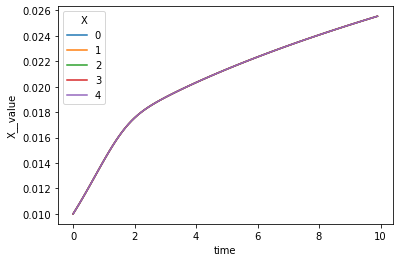

In [44]:
out_a.X__value.plot.line(x='time')

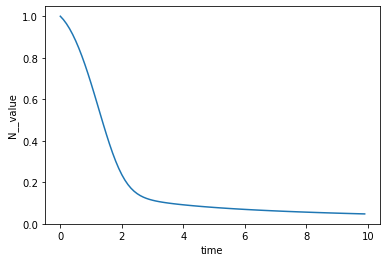

In [45]:
out_a.N__value.plot.line(x='time')

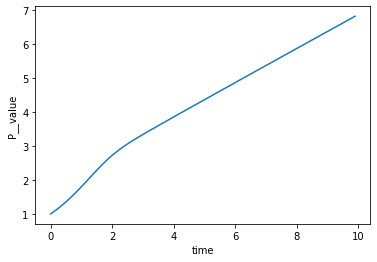

In [46]:
out_a.P__value.plot.line(x='time')

# for later reference, for higher dimensionality:

In [163]:
def initialize_array(gk_class, label, shape, initval = None):
    """This function returns a labeled multi-dimensional m.array of supplied base gk_class"""
    gk_array = m.Array(gk_class, shape)
    
    it = np.nditer(gk_array, flags=['refs_ok','multi_index'], op_flags=['readwrite'])

    i=0
    while not it.finished:
        gk_array[it.multi_index].__dict__['NAME'] = f"{label}_{str(i)}"
        
        if initval != None:
            gk_array[it.multi_index].VALUE = initval
            
        i += 1
        #print(it.value)
        it.iternext()
        
    return gk_array

In [90]:
x_array = initialize_array(m.SV, 'Nutrient', (3,3,3), initval=0)

# once custom simulation stages are possible with xsimlab:
as referenced here: https://github.com/benbovy/xarray-simlab/issues/52
       


In [ ]:
@xs.process
class GekkoExplicitSolve(Solver):
    """NOT WORKING YET,
    this needs two initialize stages, which xsimlab as of yet does not provide
    
    the usefulness would be, seeing progr"""
    
    def initialize(self):
        print('initialize solver')
        self.solver_type = 'step'
        
        # ASSIGN MODEL SOLVING TIME HERE:
        self.i = 1
        
        # add solver options
        self.m.options.REDUCE = 3  # handles reduction of larger models, have not benchmarked it yet
        self.m.options.NODES = 3  # improves solution accuracy
        self.m.options.IMODE = 4  # sequential dynamic solver
        
        #to measure solve time
        self.solve_start = tm.time()
        
    def run_step(self):
        print('solver step')
        self.m.time = [self.i-1,self.i]
        
        self.m.solve(disp=False)
    
        self.i += 1
        
    def finalize_step(self):
        #print(self.m.__dict__)
        print('Running solver now')
        
        solve_end = tm.time()

        print(f"Model was solved in {round(solve_end-self.solve_start,2)} seconds")
        
        #print(self.m.__dict__)

# BACKUP

In [ ]:
    def initialize_array(self, gk_class, label, shape, initval = None):
        """ returns a labeled multi-dimensional m.array of supplied base gk_class """
        gk_array = self.m.Array(gk_class, shape)
        print(type(gk_array))
        it = np.nditer(gk_array, flags=['refs_ok','multi_index'], op_flags=['readwrite'])
        i=0
        while not it.finished:
            gk_array[it.multi_index].__dict__['NAME'] = f"{label}_{str(i)}"
            if initval != None:
                gk_array[it.multi_index].VALUE = initval
            i += 1
            it.iternext()
        return gk_array
    
    def return_array_aslist(self, gk_array):
        """ returns a list of values of before model solve """
        array_aslist = []
        it = np.nditer(gk_array, flags=['refs_ok','multi_index'], op_flags=['readwrite'])
        while not it.finished:
            print(gk_array[it.multi_index])
            array_aslist.append(gk_array[it.multi_index].value)
            it.iternext()
        return array_aslist
    
    def initialize_equations(self, gk_array, fluxes):
        """ adds equation references to gekko backend """
        it = np.nditer(gk_array, flags=['refs_ok','multi_index'], op_flags=['readwrite'])
        while not it.finished:
            self.m.Equation(
            gk_array[it.multi_index].dt() == sum([flux[it.multi_index] for flux in fluxes])
                )
            it.iternext()
        return gk_array